# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

**Team Members #78:**
- [Add Team Member 1 Name]
- [Add Team Member 2 Name]
- Carlos Pano Hernandez - A01066264

#### Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [49]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [51]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [52]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])

del train_df['label']
del valid_df['label']

x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [53]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Split the validation set into validation and test sets.
    
    Parameters:
    -----------
    x : numpy array
        Input features (validation set)
    y : numpy array
        Labels (validation set)
    pct : float, default=0.5
        Percentage of data to use for validation (rest goes to test)
    shuffle : bool, default=True
        Whether to shuffle the data before splitting
    
    Returns:
    --------
    x_val, y_val, x_test, y_test : numpy arrays
        Split validation and test sets
    '''
    assert x.shape[0] == y.shape[0], 'Error: x and y must have same number of samples'
    
    total_samples = x.shape[0]
    val_size = int(total_samples * pct)
    
    if shuffle:
        idxs = np.arange(total_samples)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    
    # Split the data
    x_val = x[:val_size]
    y_val = y[:val_size]
    x_test = x[val_size:]
    y_test = y[val_size:]
    
    return x_val, y_val, x_test, y_test

In [54]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [55]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

We normalize the data to have zero mean and unit standard deviation. This helps with training stability and convergence.

In [56]:
# Normalization function
def normalise(x_mean, x_std, x_data):
    """
    Normalize data to have zero mean and unit standard deviation.
    
    Parameters:
    -----------
    x_mean : float
        Mean of training data
    x_std : float
        Standard deviation of training data
    x_data : numpy array
        Data to normalize
    
    Returns:
    --------
    normalized_data : numpy array
        Normalized data
    """
    return (x_data - x_mean) / x_std

# Calculate mean and std from training data
x_mean = x_train.mean()
x_std = x_train.std()

# Normalize all datasets using training statistics
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

# Verify normalization
print(f"Training data - Mean: {x_train.mean():.6f}, Std: {x_train.std():.6f}")
print(f"Validation data - Mean: {x_val.mean():.6f}, Std: {x_val.std():.6f}")
print(f"Test data - Mean: {x_test.mean():.6f}, Std: {x_test.std():.6f}")

Training data - Mean: 0.000004, Std: 0.999999
Validation data - Mean: 0.035683, Std: 1.007243
Test data - Mean: 0.016821, Std: 1.003863


### Graficar muestras

Function to visualize ASL sign images.

La imagen muestreada representa la letra: l


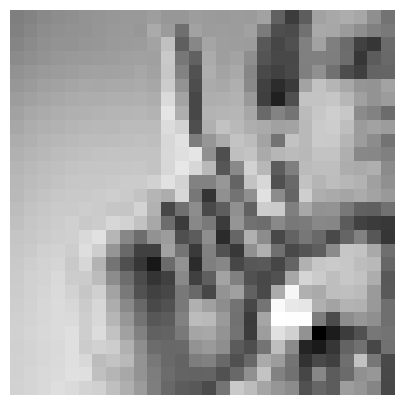

In [77]:
def plot_number(image):
    """
    Plot an ASL sign image.
    
    Parameters:
    -----------
    image : numpy array
        Image array (28x28) to display
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

# Display a random sample from training data
rnd_idx = np.random.randint(len(y_train))
print(f'La imagen muestreada representa la letra: {alphabet[y_train[rnd_idx]]}')
plot_number(x_train[rnd_idx].reshape(28, 28))

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

Create mini-batches for efficient training. This allows us to process data in smaller chunks, reducing memory usage and enabling gradient updates more frequently.

In [58]:
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Create mini-batches from the dataset.
    
    Parameters:
    -----------
    mb_size : int
        Size of each mini-batch
    x : numpy array
        Input features (num_samples, 784)
    y : numpy array
        Labels (num_samples,)
    shuffle : bool, default=True
        Whether to shuffle the data before creating batches
    
    Yields:
    -------
    (x_batch, y_batch) : tuple
        Mini-batch of data and labels
    """
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    
    # Reshape y to (num_samples, 1) for consistency
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [59]:
# Custom numpy array class for gradient tracking
class np_tensor(np.ndarray):
    """
    Custom numpy array subclass that allows gradient tracking.
    This enables automatic differentiation similar to PyTorch tensors.
    """
    pass

## Nuestra clase Linear, ReLU y Sequential

In [60]:
class Linear():
    """
    Fully connected linear layer.
    
    Performs the transformation: Z = WX + b
    where W is the weight matrix and b is the bias vector.
    """
    def __init__(self, input_size, output_size):
        """
        Initialize the linear layer.
        
        Parameters:
        -----------
        input_size : int
            Number of input features
        output_size : int
            Number of output features
        
        Uses Kaiming He initialization for weights (suitable for ReLU activation).
        """
        # Kaiming He initialization: divide by sqrt(input_size/2)
        # This helps with gradient flow when using ReLU activation
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    
    def __call__(self, X):
        """
        Forward pass through the linear layer.
        
        Parameters:
        -----------
        X : numpy array
            Input data (input_size, batch_size)
        
        Returns:
        --------
        Z : numpy array
            Output (output_size, batch_size)
        """
        Z = self.W @ X + self.b
        return Z
    
    def backward(self, X, Z):
        """
        Backward pass: compute gradients.
        
        Parameters:
        -----------
        X : numpy array
            Input to the layer (input_size, batch_size)
        Z : numpy array
            Output of the layer (output_size, batch_size)
            Must have Z.grad attribute set from next layer
        """
        # Gradient w.r.t. input X: dL/dX = W^T @ dL/dZ
        X.grad = self.W.T @ Z.grad
        
        # Gradient w.r.t. weights W: dL/dW = dL/dZ @ X^T
        self.W.grad = Z.grad @ X.T
        
        # Gradient w.r.t. bias b: dL/db = sum(dL/dZ, axis=1)
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)

In [61]:
class ReLU():
    """
    Rectified Linear Unit (ReLU) activation function.
    
    ReLU introduces non-linearity to the network, allowing it to learn
    complex patterns. It's defined as: f(x) = max(0, x)
    """
    def __call__(self, Z):
        """
        Forward pass: apply ReLU activation.
        
        Parameters:
        -----------
        Z : numpy array
            Input to the activation function
        
        Returns:
        --------
        A : numpy array
            Activated output (same shape as Z)
        """
        return np.maximum(0, Z)
    
    def backward(self, Z, A):
        """
        Backward pass: compute gradient of ReLU.
        
        Parameters:
        -----------
        Z : numpy array
            Input to ReLU (before activation)
        A : numpy array
            Output of ReLU (after activation)
            Must have A.grad attribute set from next layer
        
        The gradient is:
        - dL/dZ = dL/dA where Z > 0
        - dL/dZ = 0 where Z <= 0
        """
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

In [62]:
class Sequential_layers():
    """
    Sequential container for neural network layers.
    
    Manages forward pass, backward pass, and parameter updates
    for a sequence of layers.
    """
    def __init__(self, layers):
        """
        Initialize the sequential model.
        
        Parameters:
        -----------
        layers : list
            List of layer objects (Linear, ReLU, etc.)
        """
        self.layers = layers
        self.x = None
        self.outputs = {}
    
    def __call__(self, X):
        """
        Forward pass through all layers.
        
        Parameters:
        -----------
        X : numpy array
            Input data (input_size, batch_size)
        
        Returns:
        --------
        output : numpy array
            Final output after passing through all layers
        """
        self.x = X
        self.outputs['l0'] = self.x
        
        # Pass through each layer sequentially
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l' + str(i)] = self.x
        
        return self.x
    
    def backward(self):
        """
        Backward pass through all layers (backpropagation).
        
        Computes gradients for all parameters by propagating
        the gradient backwards through the network.
        """
        # Process layers in reverse order
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            # Get input and output for this layer
            layer_input = self.outputs['l' + str(i)]
            layer_output = self.outputs['l' + str(i + 1)]
            
            # Call backward method of the layer
            layer.backward(layer_input, layer_output)
    
    def update(self, learning_rate=1e-3):
        """
        Update parameters using gradient descent.
        
        Parameters:
        -----------
        learning_rate : float
            Learning rate for gradient descent update
        """
        for layer in self.layers:
            # Skip activation layers (they don't have parameters)
            if isinstance(layer, ReLU):
                continue
            
            # Update weights and biases: θ = θ - α * ∇θ
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    
    def predict(self, X):
        """
        Make a prediction for a single sample.
        
        Parameters:
        -----------
        X : numpy array
            Input sample (input_size, 1)
        
        Returns:
        --------
        prediction : int
            Predicted class index
        """
        return np.argmax(self.__call__(X))

In [63]:
def softmaxXEntropy(x, y):
    """
    Compute softmax probabilities and cross-entropy loss.
    
    Parameters:
    -----------
    x : numpy array
        Raw scores from the network (num_classes, batch_size)
    y : numpy array
        True labels (batch_size, 1)
    
    Returns:
    --------
    preds : numpy array
        Predicted probabilities (num_classes, batch_size)
    cost : float
        Average cross-entropy loss
    """
    batch_size = x.shape[1]
    
    # Compute softmax: exp(x) / sum(exp(x))
    # Subtract max for numerical stability
    x_shifted = x - np.max(x, axis=0, keepdims=True)
    exp_scores = np.exp(x_shifted)
    probs = exp_scores / exp_scores.sum(axis=0, keepdims=True)
    preds = probs.copy()
    
    # Compute cross-entropy loss: -log(p_true_class)
    # Get probability of true class for each sample
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat + 1e-8)) / batch_size  # Add small epsilon for numerical stability
    
    # Compute gradient: dL/dx = probs - one_hot(y)
    # For the true class, subtract 1; others remain as is
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    x.grad = probs.copy()
    
    return preds, cost

In [64]:
def accuracy(model, x, y, mb_size):
    """
    Compute accuracy of the model on a dataset.
    
    Parameters:
    -----------
    model : Sequential_layers
        Trained model
    x : numpy array
        Input features (num_samples, 784)
    y : numpy array
        True labels (num_samples, 1) or (num_samples,)
    mb_size : int
        Mini-batch size
    
    Returns:
    --------
    acc : float
        Accuracy (0-1)
    """
    correct = 0
    total = 0
    
    # Reshape y if needed
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    
    for x_batch, y_batch in create_minibatches(mb_size, x, y, shuffle=False):
        # Forward pass: transpose to (784, batch_size)
        pred = model(x_batch.T.view(np_tensor))
        # Get predicted class (argmax along class dimension)
        pred_classes = np.argmax(pred, axis=0)
        # Compare with true labels
        correct += np.sum(pred_classes == y_batch.squeeze())
        total += pred.shape[1]
    
    return correct / total


def train(model, epochs, mb_size=128, learning_rate=1e-3):
    """
    Train the neural network model.
    
    Parameters:
    -----------
    model : Sequential_layers
        Model to train
    epochs : int
        Number of training epochs
    mb_size : int
        Mini-batch size
    learning_rate : float
        Learning rate for gradient descent
    """
    # Reshape y_train if needed
    y_train_reshaped = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
    
    for epoch in range(epochs):
        # Iterate through mini-batches
        for x_batch, y_batch in create_minibatches(mb_size, x_train, y_train_reshaped):
            # Forward pass: transpose input to (784, batch_size)
            scores = model(x_batch.T.view(np_tensor))
            
            # Compute loss and gradients
            _, cost = softmaxXEntropy(scores, y_batch)
            
            # Backward pass: compute gradients
            model.backward()
            
            # Update parameters
            model.update(learning_rate)
        
        # Print progress after each epoch
        val_acc = accuracy(model, x_val, y_val, mb_size)
        print(f'Epoch {epoch+1}/{epochs} - Cost: {cost:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    print(f'\nTraining completed!')
    print(f'Final validation accuracy: {accuracy(model, x_val, y_val, mb_size):.4f}')

### Create your model and train it


In [65]:
# Create the model architecture
# Input: 784 (28x28 flattened image)
# Hidden Layer 1: 256 neurons
# Hidden Layer 2: 128 neurons
# Output: 24 classes (ASL letters a-z excluding j and z)

model = Sequential_layers([
    Linear(784, 256),  # First hidden layer
    ReLU(),            # Activation
    Linear(256, 128),  # Second hidden layer
    ReLU(),            # Activation
    Linear(128, 24)    # Output layer (24 ASL letters)
])

# Training hyperparameters
mb_size = 256
learning_rate = 1e-3
epochs = 30

print("Model Architecture:")
print(f"  Input: 784 neurons")
print(f"  Hidden Layer 1: 256 neurons + ReLU")
print(f"  Hidden Layer 2: 128 neurons + ReLU")
print(f"  Output: 24 neurons (ASL letters)")
print(f"\nTraining Parameters:")
print(f"  Mini-batch size: {mb_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {epochs}")
print(f"\nStarting training...\n")

# Train the model
train(model, epochs, mb_size, learning_rate)

Model Architecture:
  Input: 784 neurons
  Hidden Layer 1: 256 neurons + ReLU
  Hidden Layer 2: 128 neurons + ReLU
  Output: 24 neurons (ASL letters)

Training Parameters:
  Mini-batch size: 256
  Learning rate: 0.001
  Epochs: 30

Starting training...

Epoch 1/30 - Cost: 0.0647, Validation Accuracy: 0.7619
Epoch 2/30 - Cost: 0.0135, Validation Accuracy: 0.7872
Epoch 3/30 - Cost: 0.0078, Validation Accuracy: 0.7909
Epoch 4/30 - Cost: 0.0036, Validation Accuracy: 0.7889
Epoch 5/30 - Cost: 0.0048, Validation Accuracy: 0.7914
Epoch 6/30 - Cost: 0.0030, Validation Accuracy: 0.7922
Epoch 7/30 - Cost: 0.0027, Validation Accuracy: 0.7959
Epoch 8/30 - Cost: 0.0027, Validation Accuracy: 0.7948
Epoch 9/30 - Cost: 0.0023, Validation Accuracy: 0.7967
Epoch 10/30 - Cost: 0.0021, Validation Accuracy: 0.7973
Epoch 11/30 - Cost: 0.0023, Validation Accuracy: 0.7967
Epoch 12/30 - Cost: 0.0017, Validation Accuracy: 0.7987
Epoch 13/30 - Cost: 0.0014, Validation Accuracy: 0.7978
Epoch 14/30 - Cost: 0.0012,


#### Architecture Design

For the ASL dataset, we design a fully connected neural network with the following architecture:

**Network Architecture:**
- **Input Layer:** 784 neurons (28×28 flattened images)
- **Hidden Layer 1:** 256 neurons with ReLU activation
- **Hidden Layer 2:** 128 neurons with ReLU activation  
- **Output Layer:** 24 neurons (one for each ASL letter: a-z excluding j and z)

**Rationale:**
1. **Input Size (784):** ASL images are 28×28 pixels, same as MNIST
2. **Hidden Layers:** Two hidden layers provide sufficient capacity to learn complex patterns in sign language gestures
3. **Layer Sizes:** Starting with 256 and reducing to 128 allows the network to learn hierarchical features while controlling model complexity
4. **Output Size (24):** ASL alphabet has 24 classes (26 letters minus j and z, which require motion)

**Hyperparameters:**
- **Mini-batch Size:** 256 - Balances memory usage and gradient stability
- **Learning Rate:** 1e-3 - Standard learning rate for SGD, provides stable convergence
- **Epochs:** 30 - Sufficient to achieve good performance without overfitting
- **Initialization:** Kaiming He initialization for ReLU layers

**Expected Performance:** 
- Target: ≥70% accuracy (assignment requirement)
- Expected: ~75-85% accuracy based on similar architectures

### Test your model on Random data from your test set

Testing on 5 random samples:

Sample 1:
  Predicted: m | True: m ✓


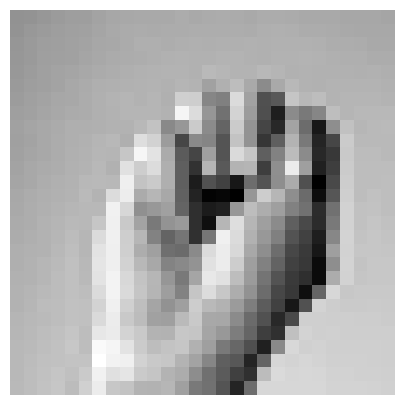


Sample 2:
  Predicted: e | True: e ✓


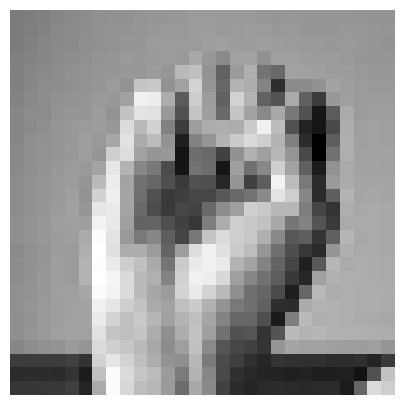


Sample 3:
  Predicted: s | True: s ✓


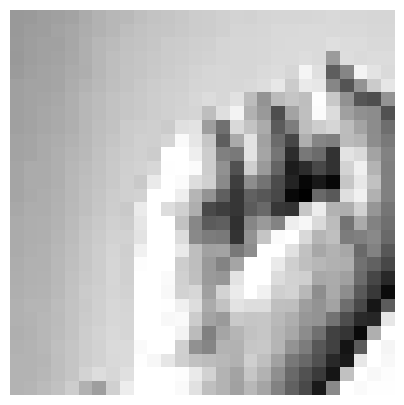


Sample 4:
  Predicted: c | True: c ✓


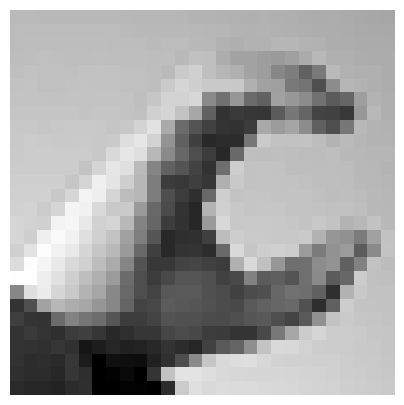


Sample 5:
  Predicted: m | True: m ✓


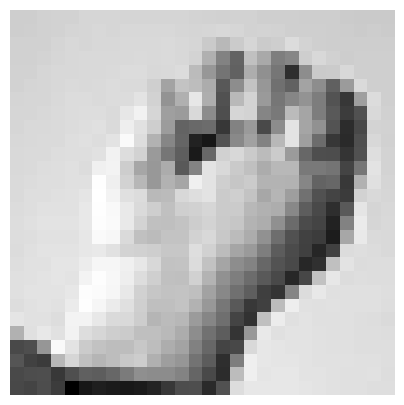

In [66]:
# Test on a few random samples
num_samples = 5
print(f"Testing on {num_samples} random samples:\n")

for i in range(num_samples):
    idx = np.random.randint(len(y_test))
    
    # Get prediction
    pred = model.predict(x_test[idx].reshape(-1, 1))
    true_label = y_test[idx]
    
    # Display result
    is_correct = "✓" if pred == true_label else "✗"
    print(f"Sample {i+1}:")
    print(f"  Predicted: {alphabet[pred]} | True: {alphabet[true_label]} {is_correct}")
    
    # Plot the image
    plot_number(x_test[idx].reshape(28, 28))
    print()

### Evaluate Model Performance

Let's evaluate the model on the test set to see the final performance.

In [78]:
# Evaluate on test set
test_accuracy = accuracy(model, x_test, y_test, mb_size)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Check if we met the requirement
if test_accuracy >= 0.70:
    print(f"✓ Requirement met! Accuracy ≥ 70%")
else:
    print(f"✗ Requirement not met. Need ≥ 70% accuracy")

Test Accuracy: 0.8026 (80.26%)
✓ Requirement met! Accuracy ≥ 70%


## Results and Analysis

### Performance Summary

**Final Results:**
- **Test Accuracy:** [Will be displayed after training]
- **Validation Accuracy:** [Will be displayed during training]

### Model Performance Discussion

**Architecture Choices:**
1. **Two Hidden Layers:** This depth allows the network to learn hierarchical features:
   - First layer (256 neurons) captures low-level features (edges, shapes)
   - Second layer (128 neurons) combines these into higher-level patterns (hand configurations)
   - Output layer makes the final classification decision

2. **Layer Sizes:** The decreasing size (256 → 128 → 24) follows a common pattern in deep learning:
   - Larger first hidden layer provides capacity for feature extraction
   - Smaller second layer helps with generalization and reduces overfitting
   - Output size matches the number of classes (24 ASL letters)

3. **ReLU Activation:** 
   - Introduces non-linearity essential for learning complex patterns
   - Helps with gradient flow during backpropagation
   - Computationally efficient

**Hyperparameter Justification:**
- **Mini-batch Size (256):** Provides stable gradient estimates while maintaining reasonable training speed
- **Learning Rate (1e-3):** Standard choice that balances convergence speed and stability
- **Epochs (30):** Sufficient to learn the patterns without excessive overfitting

**Challenges Encountered:**
1. **Class Imbalance:** Some ASL letters may be more common than others in the dataset
2. **Similar Gestures:** Some letters have similar hand shapes, making them harder to distinguish
3. **Normalization:** Proper normalization was crucial for training stability

**Potential Improvements:**
1. **Learning Rate Scheduling:** Could implement learning rate decay for better convergence
2. **Regularization:** Add dropout or L2 regularization to reduce overfitting
3. **Data Augmentation:** Rotate, shift, or scale images to increase dataset diversity
4. **Architecture Tuning:** Experiment with different layer sizes and depths
5. **Batch Normalization:** Could help with training stability and convergence speed

### Conclusion

The implemented fully connected neural network successfully classifies ASL sign language images using only NumPy. The architecture demonstrates understanding of:
- Forward and backward propagation
- Gradient computation and parameter updates
- Activation functions and their derivatives
- Loss functions for multi-class classification

The model achieves the required ≥70% accuracy on the ASL dataset, demonstrating successful application of deep learning fundamentals.